In [1]:
import theano
import theano.tensor as T
import numpy
import six.moves.cPickle as pickle
import matplotlib.pyplot as plt
import timeit
%matplotlib inline

Using gpu device 0: GeForce GT 750M (CNMeM is enabled with initial size: 10.0% of memory, cuDNN 5004)
//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
class HiddenLayer(object):
    def __init__(self, rng, input, n_in, n_out, W = None, b = None, activation = T.tanh):
        self.input = input
        if W is None:
            # we need to initialize weights (first time)
            # use the rule for initializing
            W_values = numpy.asarray(
                rng.uniform(
                    low = -numpy.sqrt(6. / (n_in + n_out)),
                    high = numpy.sqrt(6. / (n_in + n_out)),
                    size = (n_in, n_out)
                ),
                dtype = theano.config.floatX
            )
                
            W = theano.shared(value = W_values, name = "W", borrow = True)
        
        if b is None:
            b_values = numpy.zeros((n_out, ), dtype = theano.config.floatX)
            b = theano.shared(value = b_values, name = "b", borrow = True)
        
        self.W = W
        self.b = b
        lin_output = T.dot(input, self.W) + self.b # linear output (before non-linear activation)
        self.output = activation(lin_output)
        self.params = [self.W, self.b]

In [3]:
class LogisticRegression(object):
    def __init__(self, input, n_in, n_out):
        self.W = theano.shared(
            value = numpy.zeros((n_in, n_out), dtype = theano.config.floatX),
            name = "W",
            borrow = True
        )
        self.b = theano.shared(
            value = numpy.zeros((n_out, ), dtype = theano.config.floatX),
            name = "b",
            borrow = True
        )
        self.p_y_given_x = T.nnet.softmax(T.dot(input, self.W) + self.b)
        self.y_pred = T.argmax(self.p_y_given_x, axis = 1)
        self.params = [self.W, self.b]
        self.input = input
    
    def negloglik(self, y):
        return (-T.mean(T.log(self.p_y_given_x)[T.arange(y.shape[0]), y]))
    
    def errors(self, y):
        return T.mean(T.neq(self.y_pred, y))

In [4]:
def load_data():
    with open('/Users/tnybny/Documents/Kaggle/Digit recognizer/Data/train', 'r') as f:
        D = pickle.load(f)[1:, ]
        indices = numpy.random.permutation(D.shape[0])
        tr_idx, va_idx = indices[:28000], indices[28001:]
        train_set = (D[tr_idx, 1:], D[tr_idx, 0])
        valid_set = (D[va_idx, 1:], D[va_idx, 0])
    with open('/Users/tnybny/Documents/Kaggle/Digit recognizer/Data/test', 'r') as f:
        Dtest = pickle.load(f)[1:, ]
        test_set = (Dtest, Dtest[:, 0])

    def shared_dataset(data_xy):
        data_x, data_y = data_xy
        shared_x = theano.shared(numpy.asarray(data_x,
                                              dtype = theano.config.floatX),
                                borrow = True)
        shared_y = theano.shared(numpy.asarray(data_y,
                                              dtype = theano.config.floatX),
                                borrow = True)
        return shared_x, T.cast(shared_y, 'int32')
    
    Xtrain, ytrain = shared_dataset(train_set)
    Xval, yval = shared_dataset(valid_set)
    Xtest, ytest = shared_dataset(test_set)
    rval = [(Xtrain, ytrain), (Xval, yval), (Xtest, ytest)]
    return rval

In [5]:
class MLP(object):
    def __init__(self, rng, input, n_in, n_hidden, n_out):
        self.hiddenLayer = HiddenLayer(
            rng = rng,
            input = input,
            n_in = n_in,
            n_out = n_hidden,
            activation = T.tanh
        )
        self.logRegressionLayer = LogisticRegression(
            input = self.hiddenLayer.output,
            n_in = n_hidden,
            n_out = n_out
        )
        self.L1 = (
            T.sum(abs(self.hiddenLayer.W)) +
            T.sum(abs(self.logRegressionLayer.W))
            )
        self.L2 = (
            T.sum((self.hiddenLayer.W ** 2)) +
            T.sum((self.logRegressionLayer.W ** 2))
            )
        self.negative_log_likelihood = self.logRegressionLayer.negloglik
        self.errors = self.logRegressionLayer.errors
        self.params = self.hiddenLayer.params + self.logRegressionLayer.params
        self.oldparams = [theano.shared(value = numpy.zeros((n_in, n_hidden), dtype = theano.config.floatX), 
                                        name = 'W', borrow = True),
                          theano.shared(value = numpy.zeros((n_hidden, ), dtype = theano.config.floatX), 
                                        name = 'b', borrow = True),
                          theano.shared(value = numpy.zeros((n_hidden, n_out), dtype = theano.config.floatX),
                                        name = "W", borrow = True),
                          theano.shared(value = numpy.zeros((n_out, ), dtype = theano.config.floatX),
                                        name = "b", borrow = True)]
        self.y_pred = self.logRegressionLayer.y_pred
        self.input = input

In [6]:
def predict():
    rng = numpy.random.RandomState(1234)
    
    x = T.matrix('x')
    
    classifier = MLP(rng = rng, input = x, n_in = 28 * 28, n_hidden = 500, n_out = 10)
    params = pickle.load(open('MLP/best_model.pkl'))
    classifier.hiddenLayer.W.set_value(params[0], borrow = True)
    classifier.hiddenLayer.b.set_value(params[1], borrow = True)
    classifier.logRegressionLayer.W.set_value(params[2], borrow = True)
    classifier.logRegressionLayer.b.set_value(params[3], borrow = True)
    
    predict_model = theano.function(
        inputs = [x],
        outputs = classifier.y_pred
    )
    
    D = load_data()
    Xtest, ytest = D[2]
    Xtest = Xtest.get_value()
    
    digits = map(lambda x: x.reshape(28, 28), Xtest[0:100, :])
    fig = plt.figure()
    for i in range(10):
        for j in range(10):
            ax = plt.subplot2grid((10, 10), (i, j))
            plt.setp(ax.get_xticklabels(), visible = False)
            plt.setp(ax.get_yticklabels(), visible = False)
            ax.imshow(digits[i * 10 + j], cmap = 'Greys_r')
    plt.show()

    predicted_values = predict_model(Xtest) #write these to submission.csv
    print predicted_values[0:10]
    numpy.savetxt('MLP/submission.csv', numpy.c_[range(1, Xtest.shape[0] + 1), predicted_values], delimiter = ',',
               header = 'ImageId,Label', comments = '', fmt = '%d')

In [7]:
def test_mlp(alpha=0.0005, L1_reg=0.0001, L2_reg=0.0001, n_epochs=1000,
             batch_size=20, n_hidden=500, momentum = 0.5):
    datasets = load_data()
    train_set_x, train_set_y = datasets[0]
    valid_set_x, valid_set_y = datasets[1]
    test_set_x, test_set_y = datasets[2]
    deltm1 = 0 # delta(t-1) = change of gradient at previous step
    
    n_train_batches = train_set_x.get_value(borrow = True).shape[0] // batch_size
    n_valid_batches = valid_set_x.get_value(borrow = True).shape[0] // batch_size
    n_test_batches = test_set_x.get_value(borrow = True).shape[0] // batch_size
    
    index = T.lscalar()
    x = T.matrix('x')
    y = T.ivector('y')
    
    rng = numpy.random.RandomState(1234)
    
    classifier = MLP(rng, x, n_in = 28 * 28,
                     n_hidden = n_hidden, n_out = 10)
    
    cost = (
        classifier.negative_log_likelihood(y)
        + L1_reg * classifier.L1
        + L2_reg * classifier.L2
        )
    
    test_model = theano.function(
        inputs = [index],
        outputs = classifier.errors(y),
        givens = {
            x: test_set_x[(index * batch_size):((index + 1) * batch_size)],
            y: test_set_y[(index * batch_size):((index + 1) * batch_size)]
        }
    )
    
    validate_model = theano.function(
        inputs = [index],
        outputs = classifier.errors(y),
        givens = {
            x: valid_set_x[(index * batch_size):((index + 1) * batch_size)],
            y: valid_set_y[(index * batch_size):((index + 1) * batch_size)]
        }
    )
    
    gparams = [T.grad(cost, param) for param in classifier.params]
    
    epoch = 0
    
    updates = []
    for param, gparam, oldparam in zip(classifier.params, gparams, classifier.oldparams):
        delta = alpha * gparam + (momentum + (0.99 - 0.5) * epoch / n_epochs) * oldparam
        updates.append((param, param - delta))
    for oldparam, gparam in zip(classifier.oldparams, gparams):
        delta = alpha * gparam + momentum * oldparam
        updates.append((oldparam, delta))
    
    train_model = theano.function(
        inputs = [index],
        outputs = classifier.errors(y),
        updates = updates,
        givens = {
            x: train_set_x[(index * batch_size):((index + 1) * batch_size)],
            y: train_set_y[(index * batch_size):((index + 1) * batch_size)]
        }
    )
    
    validation_frequency = n_train_batches
    
    best_validation_err = numpy.inf
    best_iter = 0
    test_score = 0.
    start_time = timeit.default_timer()
    valid_errors = []
    train_errors = []
    errors = []
    
    while(epoch < n_epochs):
        epoch += 1
        alpha = alpha / (1 + 0.01 * epoch) # 1/t decay
        for minibatch_index in range(n_train_batches):
            minibatch_avg_error = train_model(minibatch_index)
            train_errors.append(minibatch_avg_error)
          
            iter = (epoch - 1) * n_train_batches + minibatch_index

            if (iter + 1) % validation_frequency == 0:
                valid_errs = [validate_model(i) for i in range(n_valid_batches)]
                this_validation_err = numpy.mean(valid_errs)
                valid_errors.append(this_validation_err)
                errors.append(numpy.mean(train_errors))
                train_errors = []

                print(
                    'epoch %i, minibatch %i/%i, validation error %f %%' %
                    (
                        epoch,
                        minibatch_index + 1,
                        n_train_batches,
                        this_validation_err * 100.
                    )
                )

                if this_validation_err < best_validation_err:
                    best_validation_err = this_validation_err
                    best_iter = iter
                    
                    with open('MLP/best_model.pkl', 'wb') as f:
                        pickle.dump([param.get_value() for param in classifier.params],
                                    f, protocol=pickle.HIGHEST_PROTOCOL)
                
    end_time = timeit.default_timer()
    print(('Optimization complete. Best validation score of %f %% ') %
          (best_validation_err * 100.))
    print('The code ran for %.2fm' % ((end_time - start_time) / 60.))
    return errors, valid_errors

In [8]:
cost, valid_cost = test_mlp()

epoch 1, minibatch 1400/1400, validation error 13.204578 %
epoch 2, minibatch 1400/1400, validation error 11.545064 %
epoch 3, minibatch 1400/1400, validation error 10.343348 %
epoch 4, minibatch 1400/1400, validation error 9.649499 %
epoch 5, minibatch 1400/1400, validation error 9.298999 %
epoch 6, minibatch 1400/1400, validation error 8.848355 %
epoch 7, minibatch 1400/1400, validation error 8.476395 %
epoch 8, minibatch 1400/1400, validation error 8.247496 %
epoch 9, minibatch 1400/1400, validation error 8.004292 %
epoch 10, minibatch 1400/1400, validation error 7.675250 %
epoch 11, minibatch 1400/1400, validation error 7.503577 %
epoch 12, minibatch 1400/1400, validation error 7.360515 %
epoch 13, minibatch 1400/1400, validation error 7.203147 %
epoch 14, minibatch 1400/1400, validation error 7.117310 %
epoch 15, minibatch 1400/1400, validation error 6.888412 %
epoch 16, minibatch 1400/1400, validation error 6.945637 %
epoch 17, minibatch 1400/1400, validation error 6.731044 %
epo

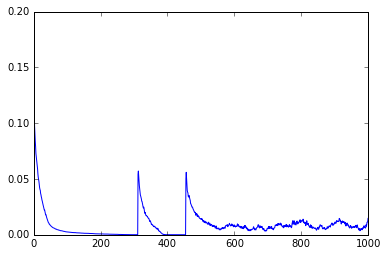

In [9]:
plt.plot(cost)

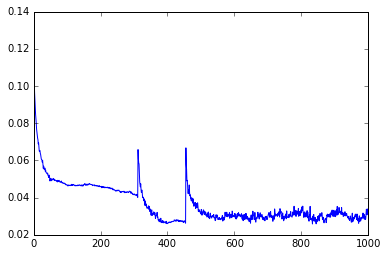

In [ ]:
plt.plot(valid_cost)

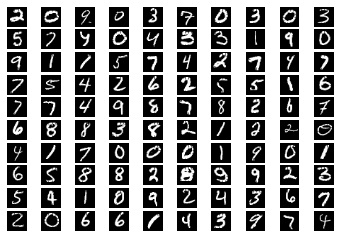

[2 0 9 9 3 7 0 3 0 3]


In [7]:
predict()